In [ ]:
# This is a series of examples using the icanswim/qchem quantum mechanic machine learning repo
# icanswim/qchem utilizes the icanswim/cosmosis data science machine learning repo

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS
from cosmosis.learning import Learn, Selector

from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import pyg_model, GraphNet

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader


In [ ]:
#example exploring cosmosis/qchem QM9 dataset with rdkit data augmentation

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atomic_number','mulliken'],
                                                             'coulomb': ['coulomb'],
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'n': 1000,
                              'use_rdkit': False,
                              'n_conformers': 1,
                              'pad': False,
                              'pad_feats': ['mulliken','coulomb','atomic_number'],
                              'as_tensor': False,
                              'use_pickle': False,
                              'flatten': False}}

qm9 = QM9(**ds_params['train_params'])
qm9[1]

In [ ]:
#example exploring cosmosis/qchem QM9 dataset with rdkit data augmentation

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atomic_number','aromatic',
                                                                   'degree','charge'],
                                                             'embed': ['hybridization','chirality'],
                                                             'coulomb': ['coulomb'],
                                                             'edge_index': ['edge_indices'],
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'n': 1000,
                              'use_rdkit': True,
                              'n_conformers': 1,
                              'pad': False,
                              'pad_feats': ['mulliken','coulomb','aromatic','degree',
                                            'charge','n_hs','n_rads','atomic_number',
                                            'hybridization','chirality'],
                              'as_tensor': False,
                              #'filter_on': ('n_atoms','<','18'),
                              'use_pickle': False,
                              'flatten': False}}

qm9 = QM9(**ds_params['train_params'])
qm9[1]

In [ ]:
#example exploring cosmosis/qchem QM9 dataset with rdkit data augmentation
l, s, li, si = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['model_input']['X'].shape[0]
    if d > l:
        l = d
        li = i
    if d < s:
        s = d
        si = i
print('longest molecule index: ', li, ' length: ', l)
print('shortest molecule index: ', si, ' length: ', s)
qm9[si]

In [ ]:
#example exploring cosmosis/qchem PyG dataset wrapper with Data object output
import numpy as np
ds_params = {'train_params': {'dataset': 'QM9',
                              'pg_params': {'root': './data/'}}}

pgds = PGDS(**ds_params['train_params'])
ds_idx = np.arange(1000)
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(pgds, batch_size=2, sampler=selector)
batch = next(iter(loader))
print(batch)
print(batch.ptr)
print(batch.idx)
print(batch.x)
print(pgds[1])
print(pgds[1].x)
print(pgds[1].idx)

In [ ]:
#example exploring cosmosis/qchem PyG dataset wrapper, padded with dictionary output
ds_params = {'train_params': {'dataset': 'QM9',
                              'use_pyg': False,
                              'pad': (29,11),
                              'pad_feats': ['x'],
                              'flatten': False,
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

pgds = PGDS(**ds_params['train_params'])
pgds[1]

In [ ]:
#example cosmosis/qchem QM9 dataset with filter, rdkit data augmentation, 
#embeddings and custom model 
rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['aromatic','degree',
                                                                   'charge','coulomb'],
                                                             'embed': ['hybridization','chirality']},
                                             'criterion_input': {'target': ['U0']}},
                              #'n': 10000, #non-random for testing
                              'use_rdkit': False,
                              'n_conformers': 1,
                              'pad': 29,
                              'pad_feats': ['mulliken','coulomb','aromatic','degree',
                                            'charge','n_hs','n_rads','atomic_number',
                                            'hybridization','chirality'],
                              'as_tensor': True,
                              'filter_on': ('n_atoms','>','10'), #filter out molecules with less than 10 atoms
                              'use_pickle': 'qm9_test.p',
                              'flatten': True}}


model_params = {'in_channels': 29+29+29+29*29+29*16+29*16, 
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel',
                'embed_params': [('hybridization',9,16,0,True),('chirality',5,16,0,True)]
               }
                
metrics_params = {'report_interval': 1,
                  'log_plot': False}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 'subset': .2 #create random subset
                }

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=256, epochs=10)

creating pytorch geometric TUDataset dataset...
CDataset created...
GNet model loaded...
CModel loaded...


Processing...
Done!


running model on gpu...


/home/operat0r/miniconda3/envs/qchem/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/home/operat0r/miniconda3/envs/qchem/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/home/operat0r/miniconda3/envs/qchem/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is 

learning time: 0:00:03.476463
epoch: 0, lr: 0.01
train loss: 0.08228098414838314, val loss: 0.07409282773733139
sklearn train metric: 0.625, sklearn validation metric: 0.75


/home/operat0r/miniconda3/envs/qchem/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/home/operat0r/miniconda3/envs/qchem/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/home/operat0r/miniconda3/envs/qchem/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is 

test loss: 0.07193528115749359
learning time: 0:00:08.608027
sklearn test metric: 
0.6666666666666666 



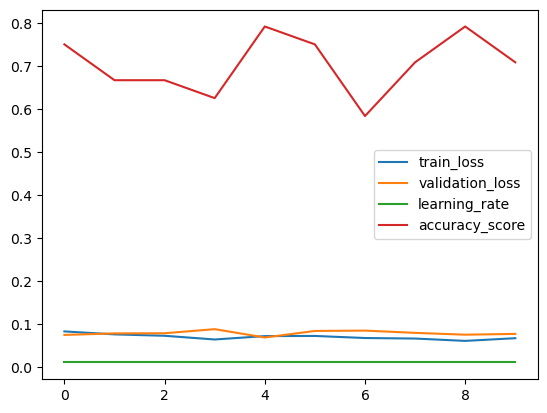

In [3]:
#example cosmosis/qchem PyG dataset wrapper with Data object output and
#sklearn metrics and custom PyG model

model_params = {'in_channels': 7,
                'hidden': 64,
                'out_channels': 2}

ds_params = {'train_params': {'dataset': 'TUDataset',
                              'use_pyg': True,
                              'pg_params': {'root': './data/',
                                            'name': 'MUTAG'}}}

metrics_params = {'report_interval': 5,
                  'log_plot': False,
                  'sk_metric_name': 'accuracy_score',
                  'sk_params': {}}

opt_params = {'lr': 0.01}

crit_params = {}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=8, epochs=10)

In [ ]:
#example cosmosis/qchem PyG dataset wrapper with custum transform with
#dictionary output and custom model
import numpy as np

class IndexTransform():
    #select index i from dataset with multiple target outputs
    def __init__(self, i):
        self.i = i
    def __call__(self, arr):
        return np.reshape(arr[self.i], (1,))

model_params = {'in_channels': 319, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'use_pyg': False,
                              'pad': (29,11),
                              'pad_feats': ['x'],
                              'flatten': True,
                              'target_transform': [IndexTransform(1)],
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=10)

In [ ]:
#example using cosmosis/qchem QM7 dataset and custom model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['ae']}},
                              'in_file': './data/qm7/qm7.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 3,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

In [ ]:
#example using the cosmosis/qchem QM7b dataset and custom model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['E']}},
                              'in_file': './data/qm7b/qm7b.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 3,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=20)

In [ ]:
#example exploring cosmosis/qchem QM7X dataset

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) with pad=23

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atNUM']},
                                             'criterion_input': {'target': ['eAT']}},
                              'pad': None, #longest molecule = 23
                              'as_tensor': False,
                              'n': 1000, #non-random subset for testing
                              'selector': ['opt'],
                              'flatten': True}}

qm7x = QM7X(**ds_params['train_params'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['model_input']['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, ' index: ', m)
print(qm7x[m]['model_input']['X'].shape) 
qm7x[m]


In [ ]:
#example using the cosmosis/qchem QM7X dataset with filter and custom model
model_params = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['eAT']}},
                              'pad': 23,
                              'selector': ['opt'],
                              'flatten': True,
                              'n': 1000, #non-random subset for testing
                             }}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .2 #create random subset
                } 

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=64, epochs=10)

In [ ]:
#example using cosmosis/qchem ANI1x dataset with filter and custom model
model_params = {'in_channels': 63*63, 
                'hidden': 2000, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['wb97x_dz.energy']}},
                              'pad_feats': ['coulomb'],
                              'pad': 63, #length of the longest molecule in the dataset
                              'flatten': True,
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=64, epochs=10)

In [ ]:
!conda list